# Evaluación de Resultados.
En este Notebook, se muestran para la evaluación de los resultado de una predicción con un algoritmo de Machine Learning(ML).
## DataSet
### Descripción
NSL-KDD is a data set suggested to solve some of the inherent problems of the KDD'99 data set which are mentioned in. Although, this new version of the KDD data set still suffers from some of the problems discussed by McHugh and may not be a perfect representative of existing real networks, because of the lack of public data sets for network-based IDSs, we believe it still can be applied as an effective benchmark data set to help researchers compare different intrusion detection methods. Furthermore, the number of records in the NSL-KDD train and test sets are reasonable. This advantage makes it affordable to run the experiments on the complete set without the need to randomly select a small portion. Consequently, evaluation results of different research work will be consistent and comparable.

### Ficheros de datos
* <span style="color:green">**KDDTrain+.ARFF**: The full NSL-KDD train set with binary labels in ARFF format</span>
* KDDTrain+.TXT: The full NSL-KDD train set including attack-type labels and difficulty level in CSV format
* KDDTrain+_20Percent.ARFF**: A 20% subset of the KDDTrain+.arff file
* KDDTrain+_20Percent.TXT: A 20% subset of the KDDTrain+.txt file
* KDDTest+.ARFF: The full NSL-KDD test set with binary labels in ARFF format
* KDDTest+.TXT: The full NSL-KDD test set including attack-type labels and difficulty level in CSV format
* KDDTest-21.ARFF: A subset of the KDDTest+.arff file which does not include records with difficulty level of 21 out of 21
* KDDTest-21.TXT: A subset of the KDDTest+.txt file which does not include records with difficulty level of 21 out of 21

## Imports

In [1]:
import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

## Funciones Auxiliares

In [2]:
def load_kdd_dataset(data_path):
    """Lectura del DataSet NSL-KDD."""
    with open(data_path, 'r') as train_set:
        dataset=arff.load(train_set)
    attributes = [attr[0] for attr in dataset["attributes"]]
    return pd.DataFrame(dataset["data"], columns = attributes)    

In [3]:
def train_val_test_split(df, rstate = 42, shuffle = True, stratify = None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size = 0.4, random_state = rstate, shuffle = shuffle, stratify = strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size = 0.5, random_state = rstate, shuffle = shuffle, stratify = strat)
    return (train_set, val_set, test_set)

In [4]:
# Construcción de un pipeline para los atributos numéricos
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = "median")),
    ('rbst_scaler', RobustScaler())
])

In [5]:
# Transformador para codificar ínicamente las columnas categoricas y devolver un DataFrame.
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse = False)
        self._columns = None
    def fit(self,X,y = None):
        X_cat = X.select_dtypes(include = ["object"])
        self._columns = pd.get_dummies(X_cat).columns
        self.oh.fit(X_cat)
        return self
    def transform(self, X, y = None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include = ["object"])
        X_num = X_copy.select_dtypes(exclude = ["object"])
        X_ca_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh,
                               columns = self._columns,
                               index = X_copy.index)
        X_copy.drop(list(X_cat), axis = 1, inplace = True)
        return X_copy.join(X_cat_oh)

In [6]:
# Transformador que prepara todo el dataset llamado Pipelines y transformadores personalizados
class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._full_pipeline = None
        self._columns = None
    def fit(self, X, y = None):
        num_attribs = list(X.select_dtypes(exclude = ['object']))
        cat_attribs = list(X.select_dtypes(include = ['object']))
        self._full_pipeline = ColumnTransformer([
            ("num", num_pipeline, num_attribs),
            ("cat", OneHotEncoder(), cat_attribs), 
        ])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
    def transform(self,X, Y =None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep, columns = self._columns, index = X_copy.index)

## Lectura del "DataSet"

In [7]:
df = load_kdd_dataset('datasets/datasets/NSL-KDD/KDDTrain+.arff')
df.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
5,0.0,tcp,private,REJ,0.0,0.0,0,0.0,0.0,0.0,...,19.0,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
6,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,9.0,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
7,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,15.0,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
8,0.0,tcp,remote_job,S0,0.0,0.0,0,0.0,0.0,0.0,...,23.0,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
9,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,13.0,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


## División del DataSet

In [8]:
# División del DataSet en los diferentes SubConjuntos
train_set, val_set, test_set = train_val_test_split(df)

In [9]:
print("Longitud del training set:", len(train_set))
print("Longitud de la validacion:", len(val_set))
print("Longitud del test set:", len(test_set))


Longitud del training set: 75583
Longitud de la validacion: 25195
Longitud del test set: 25195


Para cada auno de los subconjuntos, se separan las etiquetas de entrada.

In [10]:
# DataSet General
X_df = df.drop("class", axis = 1)
y_df = df["class"].copy()

In [11]:
# DataSet de entrenamiento
X_train = train_set.drop("class", axis = 1)
y_train = train_set["class"].copy()

In [12]:
# DataSet de validación 
X_val = val_set.drop("class", axis = 1)
y_val = val_set["class"].copy()

In [37]:
X_test = test_set.drop("class", axis = 1)
y_test = test_set["class"].copy()

## Preparacion del Dataset

In [13]:
# instanciamos nuestro transformador personalizado
data_preparer = DataFramePreparer()

In [14]:
# hacer el fit con el DataSet general, para que adquiera todos los valores posibles.
data_preparer.fit(X_df)

DataFramePreparer()

In [15]:
# Transformar el DataSet de entrenamiento
X_train_prep = data_preparer.transform(X_train)

In [16]:
X_train.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
98320,0.0,icmp,ecr_i,SF,1032.0,0.0,0,0.0,0.0,0.0,...,210.0,65.0,0.31,0.01,0.31,0.00,0.0,0.0,0.0,0.0
8590,0.0,tcp,smtp,SF,1762.0,331.0,0,0.0,0.0,0.0,...,30.0,122.0,0.73,0.07,0.03,0.02,0.0,0.0,0.0,0.0
91385,0.0,icmp,eco_i,SF,8.0,0.0,0,0.0,0.0,0.0,...,2.0,126.0,1.00,0.00,1.00,0.25,0.0,0.0,0.0,0.0
54349,0.0,tcp,csnet_ns,S0,0.0,0.0,0,0.0,0.0,0.0,...,255.0,18.0,0.07,0.07,0.00,0.00,1.0,1.0,0.0,0.0
69568,0.0,tcp,smtp,SF,1518.0,342.0,0,0.0,0.0,0.0,...,83.0,125.0,0.66,0.05,0.01,0.02,0.0,0.0,0.0,0.0
65413,0.0,tcp,http,SF,342.0,1148.0,0,0.0,0.0,0.0,...,255.0,255.0,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
106434,0.0,tcp,http,SF,247.0,11193.0,0,0.0,0.0,0.0,...,11.0,255.0,1.00,0.00,0.09,0.01,0.0,0.0,0.0,0.0
16874,0.0,tcp,http,SF,314.0,255.0,0,0.0,0.0,0.0,...,25.0,255.0,1.00,0.00,0.04,0.04,0.0,0.0,0.0,0.0
106132,0.0,udp,domain_u,SF,45.0,131.0,0,0.0,0.0,0.0,...,255.0,226.0,0.89,0.02,0.00,0.00,0.0,0.0,0.0,0.0
6183,0.0,tcp,uucp,S0,0.0,0.0,0,0.0,0.0,0.0,...,255.0,15.0,0.06,0.07,0.00,0.00,1.0,1.0,0.0,0.0


In [17]:
# Transformar el DataSet de validacion
X_val_prep = data_preparer.transform(X_val)

## Entrenamiento del Algoritmo de regresión logistica

El instanciamiento de un algoritmo de Machine Learning, utilizando Skelearn se realiza utilizando los métodos expuestos por la API de Sklearn, tal y como se ha presentado en notebooks anteriores.

In [18]:
# Entrenar el algoritmo basado en regresión logistica
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=5000)
clf.fit(X_train_prep, y_train)

/home/irbin/anaconda3/envs/Simulacion/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=5000)

## Prediccion de nuevos ejemplos

realizar una prediccion del metodo generado anteriormente tras el entrenamiento de regresion logistica se utilizara 
el subconjunto de validacion

In [24]:
y_prep = clf.predict(X_val_prep)

## 1.- Matrix de confusion

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_prep)


array([[11421,   453],
       [  258, 13063]])

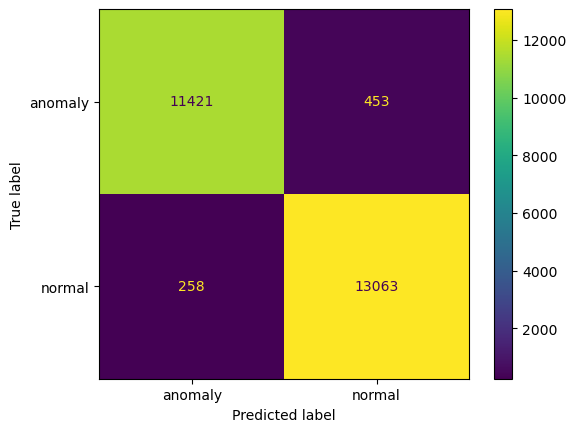

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf, X_val_prep, y_val, values_format = "3g")

## 2.- Metricas derivadas de la matrix de confusión

Precicion.

In [43]:
from sklearn.metrics import precision_score
print("precision", precision_score(y_val, y_prep, pos_label = 'anomaly'))

precision 0.9779090675571539


## Recall

In [44]:
from sklearn.metrics import recall_score
print("recall: ", recall_score(y_val, y_prep, pos_label = 'anomaly'))

recall:  0.9618494188984336


## 3.- curvas ROC Y PR

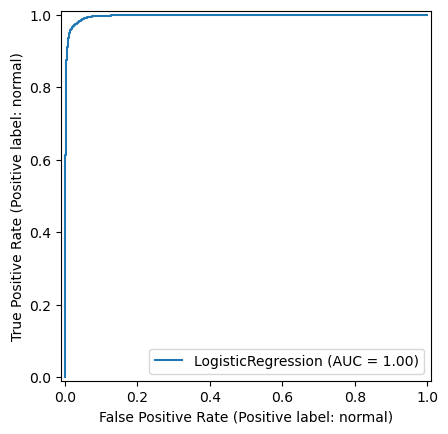

In [45]:
from sklearn.metrics import RocCurveDisplay
# plot_roc_curve(clf, X_val_prep, y_val)
#from sklearn.ensemble import RandomForestClassifier

RocCurveDisplay.from_estimator(clf, X_val_prep, y_val)


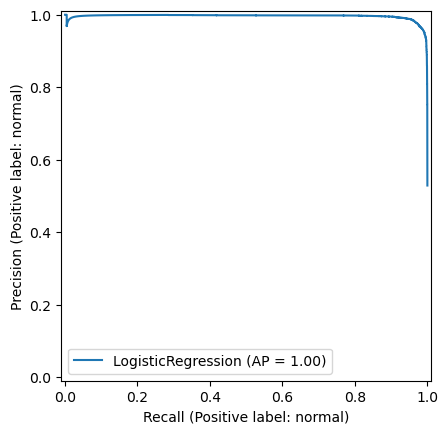

In [46]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(clf, X_val_prep, y_val)

### 4.- Evaluacion del módelo con el DataSet de pruebas 

In [47]:
#Transformar el subconjunto de Datos
X_test_prep = data_preparer.transform(test_set)
y_pred = clf.predict(X_test_prep)

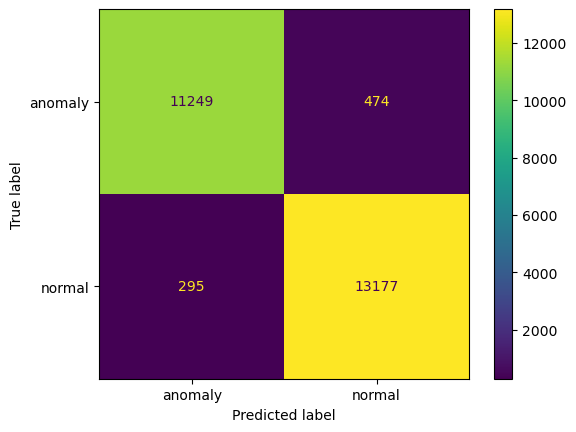

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf, X_test_prep, y_test, values_format = "3g")

In [49]:
from sklearn.metrics import f1_score
print("F1 score", f1_score(y_test, y_pred, pos_label = "anomaly"))

F1 score 0.9669488975802639
